In [22]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import torch
import msgpack
import os
import tqdm

from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# sentence-transformers/all-MiniLM-L12-v2, clip-ViT-L-14
embedding_model = 'sentence-transformers/clip-ViT-L-14'

In [3]:
df = pd.read_csv('../data/civitai_phrases_database_v6.csv')
df.head(2)

,index,total count,positive count,negative count,token size,phrase str
0,76,160021,2352,157669,2,blurry
1,57,147418,323,147095,2,bad anatomy


In [4]:
tokenizer = CLIPTokenizerFast.from_pretrained('openai/clip-vit-large-patch14')
token_lengths = []

# recompute token lengths for phrases to prevent errors when encoding phrase
for phrase in df['phrase str'].tolist():
    try:
        tokens = tokenizer.tokenize(phrase)
        token_lengths.append(len(tokens))
    except Exception as e:
        print(e)
        print(phrase)
        print(type(phrase))
        token_lengths.append(-1)
        print()
df['token_length'] = token_lengths

Token indices sequence length is longer than the specified maximum sequence length for this model (86 > 77). Running this sequence through the model will result in indexing errors


TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
nan
<class 'float'>



In [5]:
# keep phrases where token length is less than 75 and not NaN
df = df.loc[(df['token_length'] <= 75) & (df['token_length'] > 0)]
df.describe()

,index,total count,positive count,negative count,token size,token_length
count,435275.000000,435275.000000,435275.000000,435275.000000,435275.000000,435275.000000
mean,217877.283708,31.319393,13.110866,18.208528,6.763860,6.483876
std,125798.286358,886.497480,362.912529,798.855779,5.852608,5.809774
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,108941.500000,1.000000,1.000000,0.000000,3.000000,3.000000
50%,217874.000000,2.000000,1.000000,0.000000,5.000000,5.000000
75%,326826.500000,4.000000,3.000000,0.000000,8.000000,8.000000
max,435767.000000,160021.000000,109906.000000,157669.000000,92.000000,75.000000


In [6]:
df['probability'] = df['positive count'] / df['positive count'].sum()
df['log probability'] = np.log(df['probability'] + 1e-15)
df['frequency'] = 1 / df['log probability']
df.sample(3)

,index,total count,positive count,negative count,token size,phrase str,token_length,probability,log probability,frequency
263014,155542,1,1,0,13,(1 man in background fucking the girl:1.4),14,1.752286e-07,-15.557175,-0.064279
60208,186135,9,9,0,3,flower wreath,2,1.577057e-06,-13.359950,-0.074851
247397,112769,1,1,0,6,highly detailed cg unified image,5,1.752286e-07,-15.557175,-0.064279


In [8]:
df.describe(include='all')

,index,total count,positive count,negative count,token size,phrase str,token_length,probability,log probability,frequency
count,435275.000000,435275.000000,435275.000000,435275.000000,435275.000000,435275,435275.000000,4.352750e+05,435275.000000,435275.000000
unique,NaN,NaN,NaN,NaN,NaN,435275,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,blurry,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
mean,217877.283708,31.319393,13.110866,18.208528,6.763860,NaN,6.483876,2.297398e-06,-16.913785,-0.064026
std,125798.286358,886.497480,362.912529,798.855779,5.852608,NaN,5.809774,6.359264e-05,6.283818,0.013840
min,0.000000,1.000000,0.000000,0.000000,1.000000,NaN,1.000000,0.000000e+00,-34.538776,-0.253178
25%,108941.500000,1.000000,1.000000,0.000000,3.000000,NaN,3.000000,1.752286e-07,-15.557175,-0.069163
50%,217874.000000,2.000000,1.000000,0.000000,5.000000,NaN,5.000000,1.752286e-07,-15.557175,-0.064279
75%,326826.500000,4.000000,3.000000,0.000000,8.000000,NaN,8.000000,5.256857e-07,-14.458562,-0.064279


In [9]:
X_phrase, y = df['phrase str'].tolist(), df['log probability'].tolist()
Xtr_phrase, Xvl_phrase, ytr, yvl = train_test_split(X_phrase, y, test_size=0.2, random_state=42)

In [11]:
model = SentenceTransformer(embedding_model, device='cuda')

Xtr = model.encode(Xtr_phrase, convert_to_numpy=True, batch_size=1024, show_progress_bar=True)
Xvl = model.encode(Xvl_phrase, convert_to_numpy=True, batch_size=1024, show_progress_bar=True)

print(len(Xtr), len(Xvl))

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Batches:   0%|          | 0/341 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

348220 87055


In [12]:
class FCNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_prob=0.0, linear=False, out_act=False):
        super(FCNet, self).__init__()

        self.out_act = out_act

        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            if not linear:
                layers.append(nn.ReLU())
            if dropout_prob > 0:
                layers.append(nn.Dropout(p=dropout_prob))
            input_dim = hidden_dim

        self.layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.layers(x)
        output = self.output_layer(x)

        if self.out_act:
            output = nn.functional.sigmoid(output)

        return output

In [13]:
input_dim = 768 
hidden_dim = 256
output_dim = 1
num_layers = 10
dropout_prob = 0.25
linear = False
out_act = False

model = FCNet(input_dim, hidden_dim, output_dim, num_layers, dropout_prob, linear=linear, out_act=out_act)
model = model.to('cuda')

In [14]:
learning_rate = 5e-4
batch_size = 256
num_epochs = 100

save_path = '../experiments/fc'
os.makedirs(save_path, exist_ok=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {
            'input': torch.from_numpy(self.data[idx]).float(),
            'label': torch.tensor(self.labels[idx]).float()
        }
        return sample

train_dataset = CustomDataset(Xtr, ytr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(Xvl, yvl)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_loss_history = []
val_loss_history = []

best_loss = np.inf

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    train_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch['input'], batch['label']
        # Forward pass
        inputs = inputs.to('cuda')
        outputs = model(inputs)
        # Compute the loss
        targets = targets.to('cuda')
        loss = criterion(outputs, targets.unsqueeze(-1))
        train_loss += loss

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient tracking for validation
        for batch in val_loader:
            inputs = batch['input'].to('cuda')
            labels = batch['label'].to('cuda')
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.unsqueeze(-1)).item()
    val_loss /= len(val_loader)

    val_loss_history.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model, os.path.join(save_path, 'best.pt'))

    # Print the average loss for this epoch
    train_loss_history.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.8f}  Val Loss: {val_loss:.8f}')

torch.save(model, os.path.join(save_path, 'last.pt'))

Epoch [1/100] - Loss: 31.67280769  Val Loss: 20.92744719
Epoch [2/100] - Loss: 22.21881676  Val Loss: 19.01101765


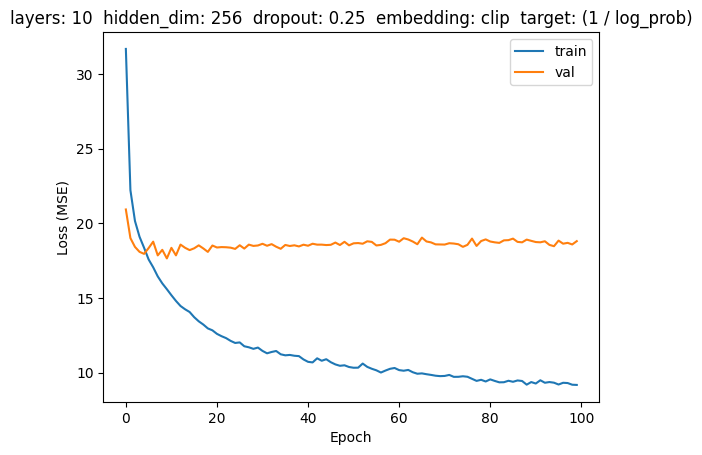

In [17]:
train_loss_history = [m.cpu().detach() for m in train_loss_history]

plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.legend()
plt.title('layers: 10  hidden_dim: 256  dropout: 0.25  embedding: clip  target: (1 / log_prob)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.savefig(os.path.join(save_path, 'loss.jpg'))
plt.show()

In [18]:
# save outputs and results

# predict on everything
pred_tr = []
pred_vl = []
model.eval()
with torch.no_grad():
    for batch in train_loader:
        inputs = batch['input'].to('cuda')
        labels = batch['label'].to('cuda')
        outputs = model(inputs)
        pred_tr.append(outputs)

    for batch in val_loader:
        inputs = batch['input'].to('cuda')
        labels = batch['label'].to('cuda')
        outputs = model(inputs)
        pred_vl.append(outputs)

pred_tr = torch.cat(pred_tr, axis=0).cpu().numpy()
pred_vl = torch.cat(pred_vl, axis=0).cpu().numpy()

In [30]:
df_tr = df[df['phrase str'].isin(Xtr_phrase)]
df_tr['pred log prob'] = pred_tr.reshape(-1).tolist()

df_vl = df[df['phrase str'].isin(Xvl_phrase)]
df_vl['pred log prob'] = pred_vl.reshape(-1).tolist()

df_res = pd.concat([df_tr, df_vl], axis=0)
df_res.to_csv('../output/fc_logprob_results.csv')

/tmp/ipykernel_110688/3598381675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr['pred log prob'] = pred_tr.reshape(-1).tolist()
/tmp/ipykernel_110688/3598381675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vl['pred log prob'] = pred_vl.reshape(-1).tolist()


In [40]:
df_tr_dict = df_tr.to_dict(orient='records')
pbar = tqdm.tqdm(enumerate(df_tr_dict), total=len(Xtr))
for idx, row in pbar:
    row['embedding'] = Xtr[idx].tolist()
    msgpack_path = os.path.join('../output/data_msgpack', f'{str(row["index"]).zfill(7)}.msgpack')
    with open(msgpack_path, 'wb') as f:
        msgpack.dump(row, f)
    pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 348220/348220 [00:28<00:00, 12074.88it/s]


In [42]:
df_vl_dict = df_vl.to_dict(orient='records')
pbar = tqdm.tqdm(enumerate(df_vl_dict), total=len(Xvl))
for idx, row in pbar:
    row['embedding'] = Xvl[idx].tolist()
    msgpack_path = os.path.join('../output/data_msgpack', f'{str(row["index"]).zfill(7)}.msgpack')
    with open(msgpack_path, 'wb') as f:
        msgpack.dump(row, f)
    pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87055/87055 [00:09<00:00, 9322.81it/s]
